### Imports 

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
from fastai.imports import *
from fastai.structured import *

from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display

from sklearn import metrics

In [3]:
import lightgbm as lgb

### Const and Func

In [10]:
path = Path('data/dataset/')

In [11]:
path

PosixPath('data/dataset')

In [12]:
! ls {path}

!dataset_fields_description.xlsx sample-submit-zero.csv
bs_avg_kpi.csv                   test
bs_chnn_kpi.csv                  train


In [13]:
! ls {path/'train'}

subs_bs_consumption_train.csv   subs_csi_train.csv
subs_bs_data_session_train.csv  subs_features_train.csv
subs_bs_voice_session_train.csv


In [14]:
def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000): 
        display(df)

### Loads

In [15]:
train_ids = pd.read_csv(path/'train/subs_csi_train.csv', sep=';')

In [16]:
test_ids = pd.read_csv(path/'test/subs_csi_test.csv', sep=';')

In [17]:
features_train = pd.read_csv(path/'train/subs_features_train.csv', sep=';', decimal=',', 
                              parse_dates=['SNAP_DATE'], infer_datetime_format=True, dayfirst=True)

In [18]:
features_test = pd.read_csv(path/'test/subs_features_test.csv', sep=';', decimal=',', 
                              parse_dates=['SNAP_DATE'], infer_datetime_format=True, dayfirst=True)

In [22]:
# convert to months (int)
features_train.SNAP_DATE = features_train.SNAP_DATE.dt.month

In [23]:
# convert to months (int)
features_test.SNAP_DATE = features_test.SNAP_DATE.dt.month

###  Data processing

In [24]:
train_ids.SK_ID.nunique(), features_train.SK_ID.nunique()

(4222, 4222)

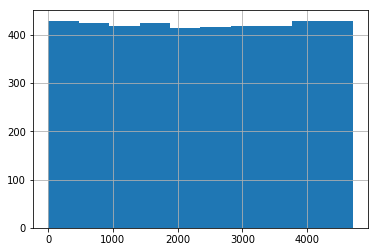

In [25]:
train_ids.SK_ID.hist();

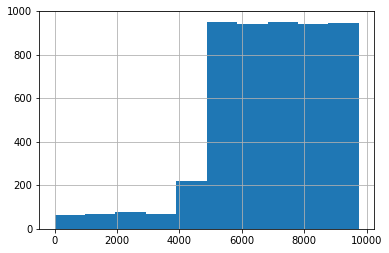

In [26]:
test_ids.SK_ID.hist();

#### Take only recent 3 months

In [29]:
features_test.SNAP_DATE.unique()

array([10,  7,  6,  1,  8,  4,  5, 11,  9,  2, 12,  3])

In [34]:
features_train = features_train[features_train.SNAP_DATE.isin([1,2,3])]
features_test = features_test[features_test.SNAP_DATE.isin([1,2,3])]

### Pivoting feature tables

In [35]:
# to merge column names later on
features_train.SNAP_DATE = features_train.SNAP_DATE.astype(str)

In [36]:
# to merge column names later on
features_test.SNAP_DATE = features_test.SNAP_DATE.astype(str)

In [37]:
tr_pivot = features_train.pivot(index='SK_ID', columns='SNAP_DATE')

In [38]:
test_pivot = features_test.pivot(index='SK_ID', columns='SNAP_DATE')

In [49]:
tr_pivot.head()

,SK_ID,COM_CAT#1_1,COM_CAT#1_2,COM_CAT#1_3,COM_CAT#2_1,COM_CAT#2_2,COM_CAT#2_3,COM_CAT#3_1,COM_CAT#3_2,COM_CAT#3_3,...,COM_CAT#32_2,COM_CAT#32_3,COM_CAT#33_1,COM_CAT#33_2,COM_CAT#33_3,COM_CAT#34_1,COM_CAT#34_2,COM_CAT#34_3,CSI,CONTACT_DATE
0,2,7.0,7.0,7.0,77.0,77.0,77.0,17.0,9.0,10.0,...,0.027579,0.027579,0.103896,0.103896,0.103896,NaN,NaN,NaN,0,1900-05-04
1,3,4.0,4.0,4.0,51.0,51.0,51.0,12.0,13.0,14.0,...,0.027579,0.027579,0.103896,0.103896,0.103896,9.0,9.0,9.0,0,1900-05-21
2,4,8.0,8.0,8.0,12.0,12.0,12.0,4.0,4.0,4.0,...,0.027579,0.027579,0.103896,0.103896,0.103896,3.0,3.0,3.0,0,1900-05-27
3,5,3.0,3.0,3.0,79.0,79.0,79.0,2.0,2.0,3.0,...,0.027579,0.027579,0.103896,0.103896,0.103896,2.0,2.0,2.0,0,1900-05-08
4,6,5.0,5.0,5.0,48.0,48.0,48.0,5.0,5.0,5.0,...,0.027579,0.027579,0.103896,0.103896,0.103896,3.0,3.0,3.0,1,1900-05-06


In [50]:
test_pivot.head()

,SK_ID,CONTACT_DATE,COM_CAT#1_1,COM_CAT#1_2,COM_CAT#1_3,COM_CAT#2_1,COM_CAT#2_2,COM_CAT#2_3,COM_CAT#3_1,COM_CAT#3_2,...,COM_CAT#31_3,COM_CAT#32_1,COM_CAT#32_2,COM_CAT#32_3,COM_CAT#33_1,COM_CAT#33_2,COM_CAT#33_3,COM_CAT#34_1,COM_CAT#34_2,COM_CAT#34_3
0,6184,1900-04-02,4.0,4.0,4.0,50.0,50.0,50.0,5.0,5.0,...,0.051047,0.027579,0.027579,0.027579,0.103896,0.103896,0.103896,9.0,9.0,9.0
1,5175,1900-04-18,3.0,3.0,3.0,24.0,24.0,24.0,5.0,5.0,...,0.037340,0.027579,0.027579,0.027579,0.103896,0.103896,0.103896,2.0,2.0,2.0
2,5478,1900-04-02,6.0,6.0,6.0,55.0,55.0,55.0,5.0,5.0,...,0.021352,0.027579,0.027579,0.027579,0.103896,0.103896,0.103896,1.0,1.0,1.0
3,7807,1900-04-14,6.0,6.0,6.0,71.0,71.0,71.0,17.0,9.0,...,0.065831,0.027579,0.027579,0.027579,0.103896,0.103896,0.103896,NaN,NaN,NaN
4,5640,1900-04-03,8.0,8.0,8.0,40.0,40.0,40.0,5.0,5.0,...,0.071405,0.027579,0.027579,0.027579,0.103896,0.103896,0.103896,2.0,2.0,2.0


In [41]:
tr_pivot.columns = ['_'.join(col) for col in tr_pivot.columns]

In [42]:
test_pivot.columns = ['_'.join(col) for col in test_pivot.columns]

In [43]:
tr_pivot.reset_index(inplace=True)

In [44]:
test_pivot.reset_index(inplace=True)

In [45]:
# add contact date and labels
tr_pivot = pd.merge(tr_pivot, train_ids, on='SK_ID')

In [46]:
test_pivot = pd.merge(test_ids, test_pivot, on='SK_ID', how='left')

In [47]:
tr_pivot['CONTACT_DATE'] = pd.to_datetime(tr_pivot['CONTACT_DATE'], format='%d.%m')

In [48]:
test_pivot['CONTACT_DATE'] = pd.to_datetime(test_pivot['CONTACT_DATE'], format='%d.%m')

#### Process with fastai structured

In [51]:
tr_pivot['CONTACT_DATE'] = tr_pivot['CONTACT_DATE'].dt.day
test_pivot['CONTACT_DATE'] = test_pivot['CONTACT_DATE'].dt.day

In [52]:
train_cats(tr_pivot)

In [53]:
apply_cats(test_pivot, tr_pivot)

In [54]:
tr_pivot.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4114 entries, 0 to 4113
Columns: 105 entries, SK_ID to CONTACT_DATE
dtypes: category(3), float64(99), int64(3)
memory usage: 3.2 MB


In [55]:
test_pivot.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5221 entries, 0 to 5220
Columns: 104 entries, SK_ID to COM_CAT#34_3
dtypes: category(3), float64(99), int64(2)
memory usage: 4.1 MB


In [56]:
os.makedirs('data/tmp', exist_ok=True)

In [157]:
tr_pivot.to_feather('data/tmp/train-features-raw')

In [158]:
test_pivot.to_feather('data/tmp/test-features-raw')

### Train

In [224]:
df, y, nas = proc_df(tr_pivot.drop('SK_ID', axis=1), 'CSI')

In [225]:
test, _, _ = proc_df(test_pivot.drop('SK_ID', axis=1), na_dict=nas)

In [226]:
m = RandomForestClassifier(n_jobs=-1, n_estimators=10)
m.fit(df, y)
m.score(df, y)

0.9735051045211472

In [227]:
def split_vals(a,n): return a[:n], a[n:]
n_valid = 400
n_trn = len(df)-n_valid
X_train, X_valid = split_vals(df, n_trn)
y_train, y_valid = split_vals(y, n_trn)

In [228]:
X_valid.shape

(400, 202)

In [229]:
def print_score(m):
    res = [metrics.roc_auc_score(y_train, m.predict_proba(X_train)[:,1]), 
           metrics.roc_auc_score(y_valid, m.predict_proba(X_valid)[:,1]),
           m.score(X_train, y_train), m.score(X_valid, y_valid)]
    
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

In [239]:
m = RandomForestClassifier(n_jobs=-1, n_estimators=100, min_samples_leaf=12, max_features=0.8, 
                           random_state=111, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.9948353326443479, 0.5575685215946844, 0.8422186322024772, 0.86, 0.841949380721594]


In [258]:
m = lgb.LGBMClassifier()
m.fit(X_train, y_train)
print_score(m)

[0.9998125901297105, 0.4679194352159468, 0.9633817985998923, 0.855]


### Feature Importance 

In [240]:
fi = rf_feat_importance(m, df)

In [241]:
fi[:10]

,cols,imp
92,COM_CAT#31_3,0.033283
78,COM_CAT#27_1,0.032673
79,COM_CAT#27_2,0.030299
90,COM_CAT#31_1,0.030215
23,COM_CAT#8_3,0.028759
45,COST_1,0.027516
39,RENT_CHANNEL_1,0.025119
40,RENT_CHANNEL_2,0.024892
47,COST_3,0.024094
38,VAS_3,0.024024


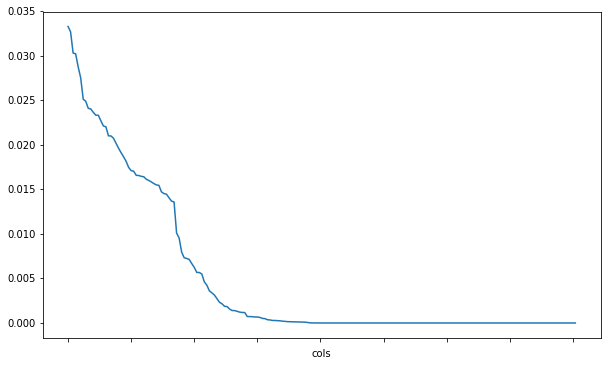

In [242]:
fi.plot('cols', 'imp', figsize=(10,6), legend=False);

In [243]:
def plot_fi(fi): return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

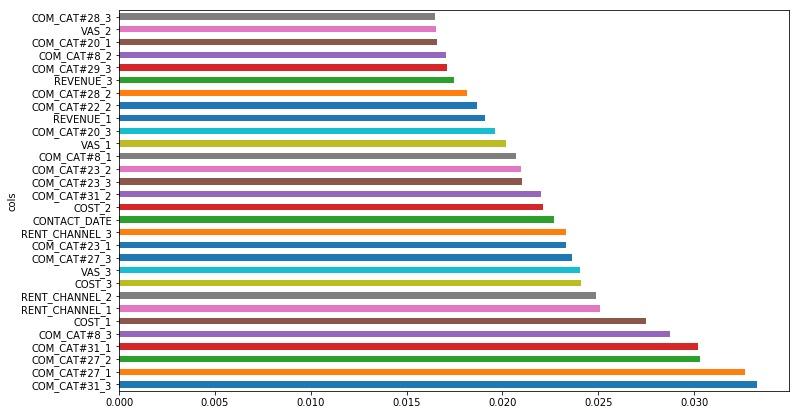

In [244]:
plot_fi(fi[:30]);

In [245]:
fi.describe()

,imp
count,202.000000
mean,0.004950
std,0.008554
min,0.000000
25%,0.000000
50%,0.000000
75%,0.006101
max,0.033283


In [255]:
to_keep = fi[fi.imp>0.02].cols; len(to_keep)

20

In [256]:
df_keep = df[to_keep].copy()
X_train, X_valid = split_vals(df_keep, n_trn)

In [257]:
m = RandomForestClassifier(n_jobs=-1, n_estimators=100, min_samples_leaf=12, max_features=0.8, 
                           random_state=111, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.9905183680740748, 0.5154173588039866, 0.8422186322024772, 0.86, 0.841949380721594]


### Predict on test and submit

In [208]:
m = RandomForestClassifier(n_jobs=-1, n_estimators=100, min_samples_leaf=12, max_features=0.8, 
                           random_state=111)
m.fit(df_keep, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=0.8, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=12, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=111, verbose=0, warm_start=False)

In [173]:
m = lgb.LGBMClassifier()
m.fit(df, y)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        learning_rate=0.1, max_depth=-1, min_child_samples=20,
        min_child_weight=0.001, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=31, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

In [209]:
pred_y = m.predict_proba(test[to_keep])[:,1]

In [210]:
subm = pd.DataFrame(pred_y)

In [211]:
subm.shape

(5221, 1)

In [214]:
subm.to_csv('submits/new_rf_no_id_fi.csv', index=False, header=False)